170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training with VGG16 as feature extractor...

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1241 - loss: 2.3449 - val_accuracy: 0.2750 - val_loss: 2.1004
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3093 - loss: 2.0426 - val_accuracy: 0.3480 - val_loss: 1.9217
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3611 - loss: 1.8686 - val_accuracy: 0.3570 - val_loss: 1.8398
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3710 - loss: 1.7691 - val_accuracy: 0.3570 - val_loss: 1.7832
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4094 - loss: 1.7170 - val_accuracy: 0.3930 - val_loss: 1.7043
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step

Classification Report for VGG

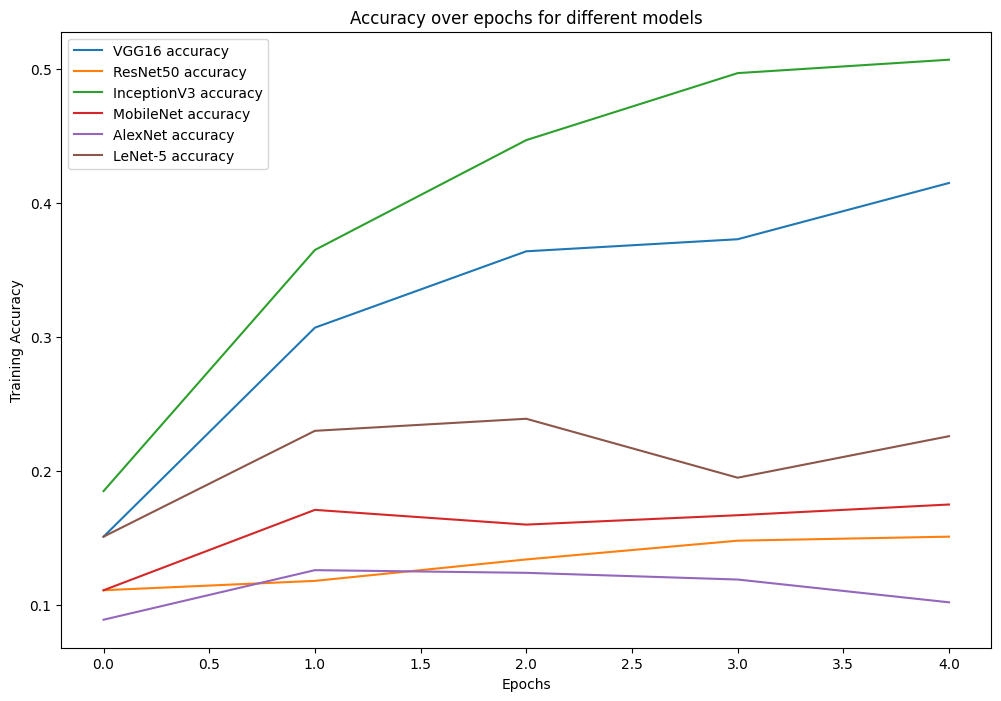

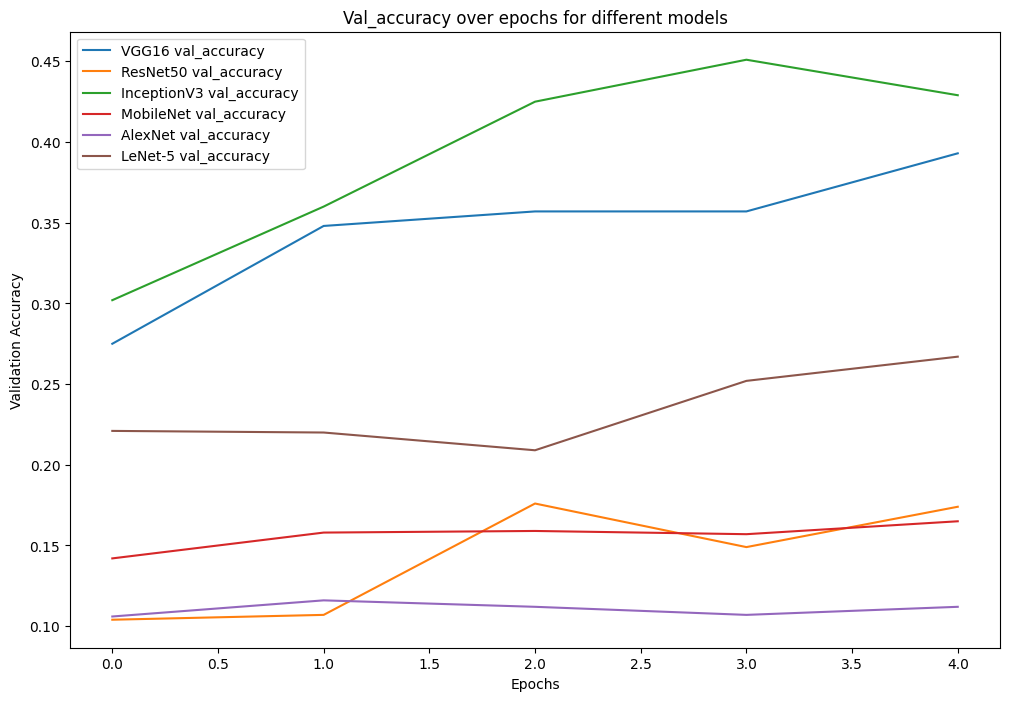

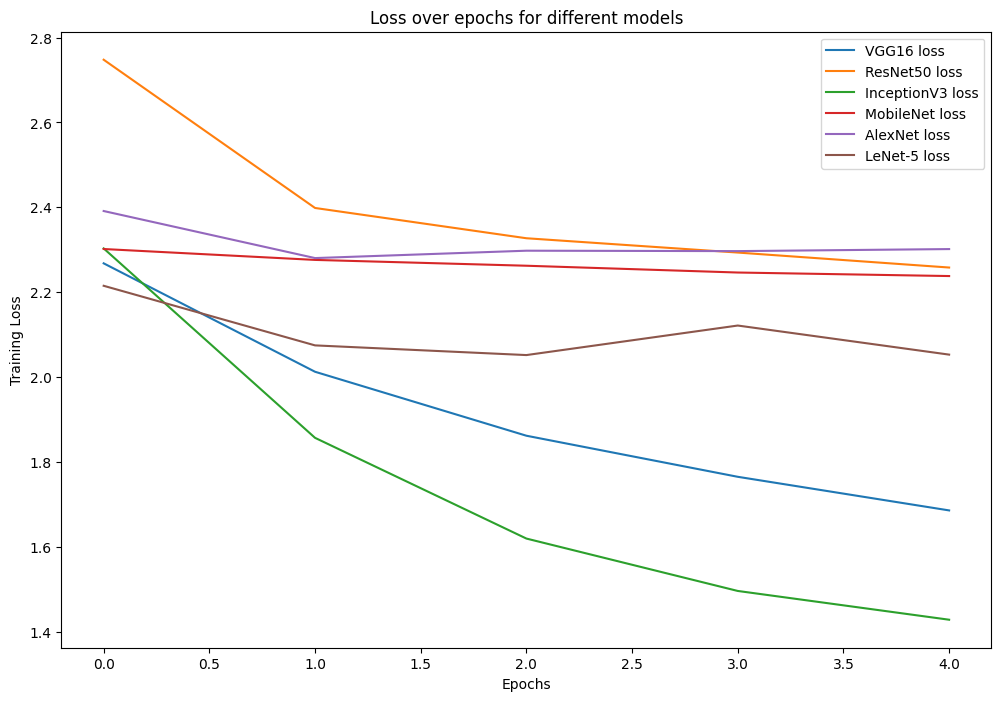

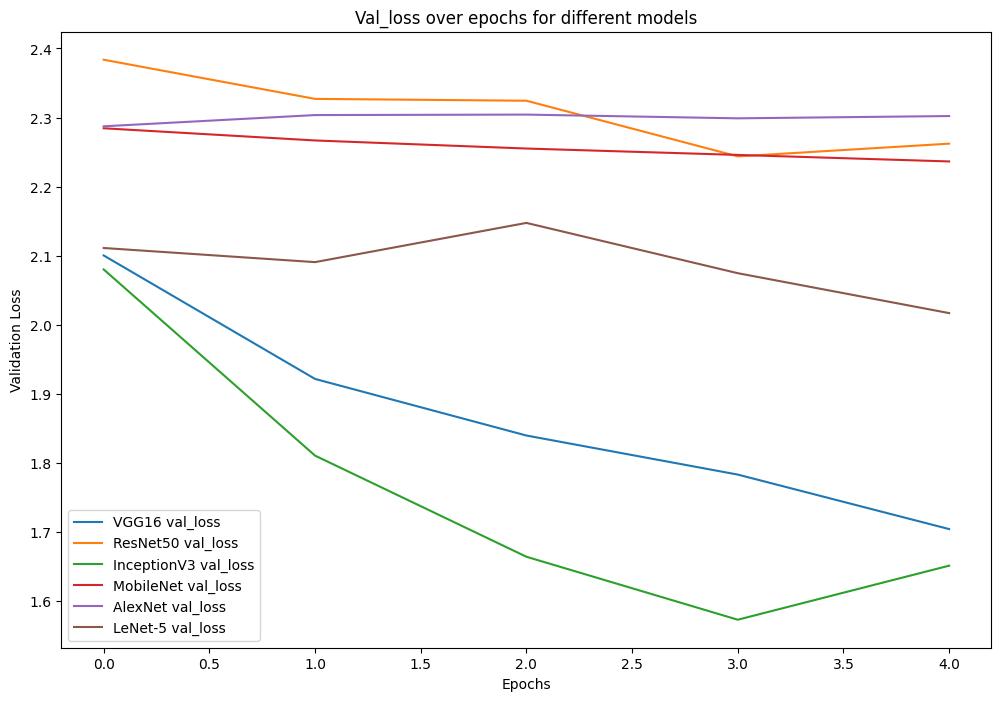

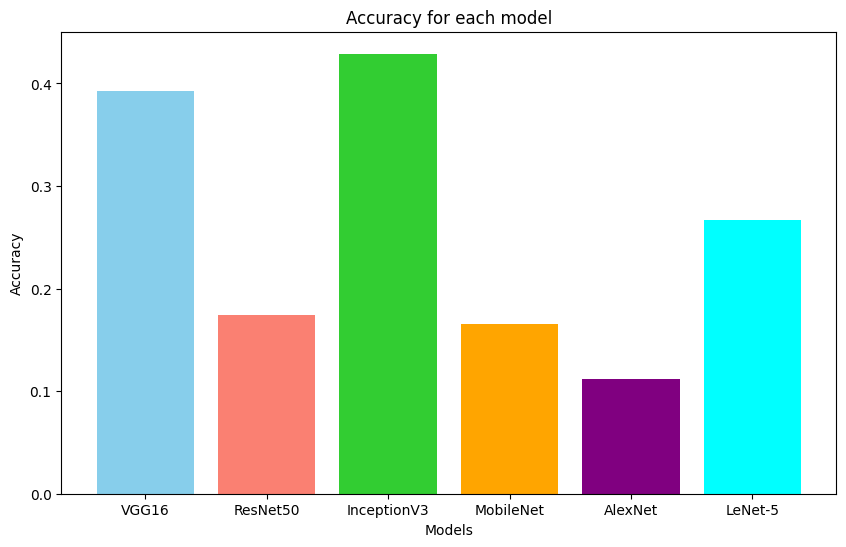

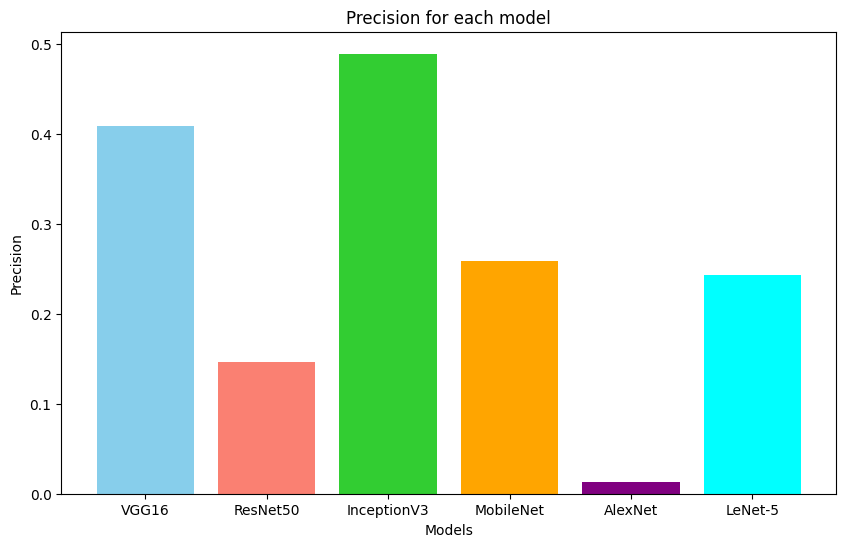

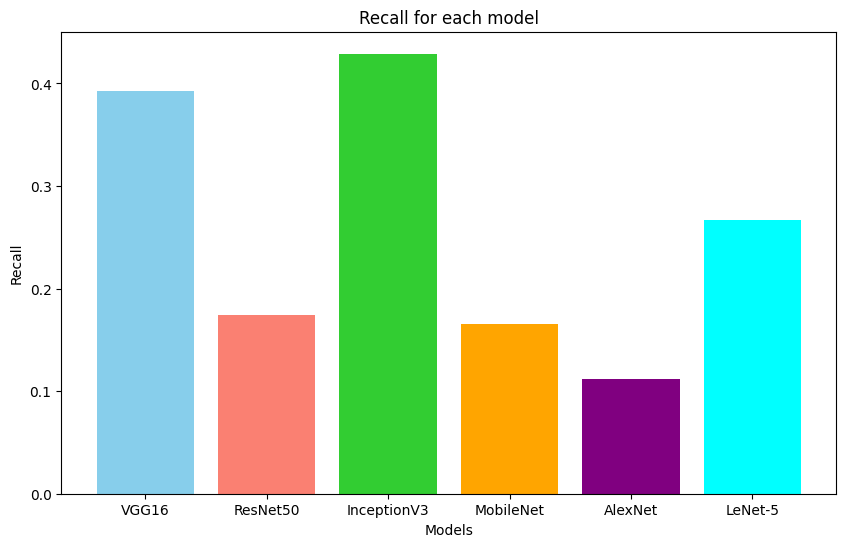

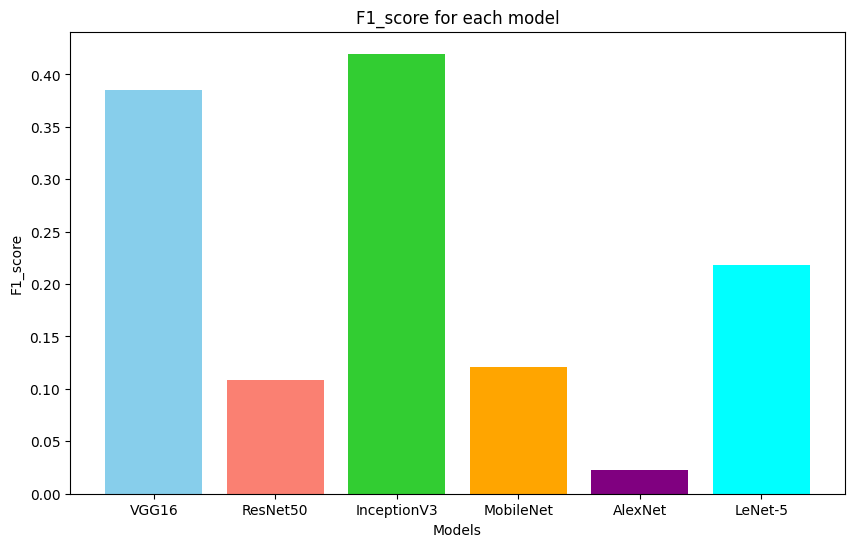

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:1000], y_test[:1000]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images

def resize_images(images, target_size):
    return np.array([tf.image.resize(image, target_size) for image in images])

def create_model(base_model):
    base_model.trainable = False  # Freeze the base model
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lenet5():
    model = tf.keras.Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32, 32, 3)),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(120, kernel_size=(5, 5), activation='tanh'),
        Flatten(),
        Dense(84, activation='tanh'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_alexnet():
    model = tf.keras.Sequential([
        Conv2D(96, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=(150, 150, 3)),
        AveragePooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(256, kernel_size=(5, 5), activation='relu'),
        AveragePooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, kernel_size=(3, 3), activation='relu'),
        Conv2D(384, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        AveragePooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(x_train)

models_info = {
    "VGG16": {"model": VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3)), "input_size": (32, 32)},
    "ResNet50": {"model": ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3)), "input_size": (32, 32)},
    "InceptionV3": {"model": InceptionV3(weights="imagenet", include_top=False, input_shape=(75, 75, 3)), "input_size": (75, 75)},
    "MobileNet": {"model": MobileNet(weights="imagenet", include_top=False, input_shape=(32, 32, 3)), "input_size": (32, 32)},
    "AlexNet": {"model": create_alexnet(), "input_size": (150, 150)},
    "LeNet-5": {"model": create_lenet5(), "input_size": (32, 32)}
}

history_data = {}
metrics_data = {}

for model_name, info in models_info.items():
    print(f"\nTraining with {model_name} as feature extractor...\n")
    x_train_resized = resize_images(x_train, info["input_size"])
    x_test_resized = resize_images(x_test, info["input_size"])
    model = info["model"] if model_name in ["LeNet-5", "AlexNet"] else create_model(info["model"])
    history = model.fit(datagen.flow(x_train_resized, y_train, batch_size=64), epochs=5, validation_data=(x_test_resized, y_test), verbose=1)
    history_data[model_name] = history.history

    y_pred = np.argmax(model.predict(x_test_resized), axis=1)
    y_true = y_test.flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = np.mean(y_pred == y_true)

    metrics_data[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

def plot_metrics(history_data, metric, ylabel):
    plt.figure(figsize=(12, 8))
    for model_name, history in history_data.items():
        plt.plot(history[metric], label=f"{model_name} {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"{metric.capitalize()} over epochs for different models")
    plt.show()

plot_metrics(history_data, 'accuracy', 'Training Accuracy')
plot_metrics(history_data, 'val_accuracy', 'Validation Accuracy')
plot_metrics(history_data, 'loss', 'Training Loss')
plot_metrics(history_data, 'val_loss', 'Validation Loss')

def plot_final_metrics(metrics_data):
    metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(metrics_data.keys()))

    for metric in metrics_names:
        plt.figure(figsize=(10, 6))
        values = [metrics_data[model][metric] for model in metrics_data.keys()]
        plt.bar(metrics_data.keys(), values, color=['skyblue', 'salmon', 'limegreen', 'orange', 'purple', 'cyan'])
        plt.xlabel("Models")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} for each model")
        plt.show()

plot_final_metrics(metrics_data)